In [1]:
import jax
import jax.numpy as jnp
import optax
import flax.linen as nn

import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt

import os
from glob import glob

import pandas as pd

from model import dce_net
from utils import plot_results, fit
from loss_functions import SpatialConsistencyLoss
from utils import get_enhanced_image

In [2]:
def get_dataset(path):
    dataset = tf.keras.utils.image_dataset_from_directory(
        path, labels=None, image_size=(256, 256), batch_size=128
    )
    lst = []
    for batch in dataset:
        lst.extend(batch / 255)
    return jnp.array(lst)

In [4]:
imgs = get_dataset("datasets/train")

Found 1207 files belonging to 1 classes.


2022-08-10 20:15:16.512565: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64
2022-08-10 20:15:16.512607: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


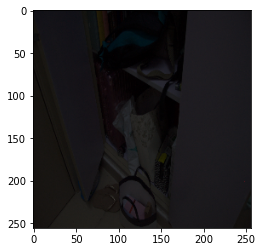

In [5]:
plt.imshow(imgs[123])

## Train

In [6]:
model = dce_net(SpatialConsistencyLoss())

In [7]:
model.tabulate(jax.random.PRNGKey(0), jnp.ones((1, 256, 256, 3)))

                        dce_net Summary                         
┏━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ outputs               ┃ params                     ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Inputs  │ float32[1,256,256,3]  │                            │
├─────────┼───────────────────────┼────────────────────────────┤
│ Conv_0  │ float32[1,256,256,32] │ bias: float32[32]          │
│         │                       │ kernel: float32[3,3,3,32]  │
│         │                       │                            │
│         │                       │ 896 (3.6 KB)               │
├─────────┼───────────────────────┼────────────────────────────┤
│ Conv_1  │ float32[1,256,256,32] │ bias: float32[32]          │
│         │                       │ kernel: float32[3,3,32,32] │
│         │                       │                            │
│         │                       │ 9,248 (37.0 KB)            │
├─────────┼───────────────────────┼────────────────────────────┤
│ Conv_2  │ float32[1,256,256,32] │ bias: float32[32]          │
│         │                       │ kernel: float32[3,3,32,32] │
│         │                       │                            │
│         │                       │ 9,248 (37.0 KB)            │
├─────────┼───────────────────────┼────────────────────────────┤
│ Conv_3  │ float32[1,256,256,32] │ bias: float32[32]          │
│         │                       │ kernel: float32[3,3,32,32] │
│         │                       │                            │
│         │                       │ 9,248 (37.0 KB)            │
├─────────┼───────────────────────┼────────────────────────────┤
│ Conv_4  │ float32[1,256,256,32] │ bias: float32[32]          │
│         │                       │ kernel: float32[3,3,64,32] │
│         │                       │                            │
│         │                       │ 18,464 (73.9 KB)           │
├─────────┼───────────────────────┼────────────────────────────┤
│ Conv_5  │ float32[1,256,256,32] │ bias: float32[32]          │
│         │                       │ kernel: float32[3,3,64,32] │
│         │                       │                            │
│         │                       │ 18,464 (73.9 KB)           │
├─────────┼───────────────────────┼────────────────────────────┤
│ Conv_6  │ float32[1,256,256,24] │ bias: float32[24]          │
│         │                       │ kernel: float32[3,3,64,24] │
│         │                       │                            │
│         │                       │ 13,848 (55.4 KB)           │
├─────────┼───────────────────────┼────────────────────────────┤
│ dce_net │ float32[1,256,256,24] │                            │
├─────────┼───────────────────────┼────────────────────────────┤
│         │                 Total │ 79,416 (317.7 KB)          │
└─────────┴───────────────────────┴────────────────────────────┘
                                                                
              Total Parameters: 79,416 (317.7 KB)               

'\n\n'

In [8]:
params = model.init(jax.random.PRNGKey(0), jnp.ones((1, 256, 256, 3)))

In [ ]:
params, losses = fit(
    model, params, imgs, batch_size=16, learning_rate=0.0001, epochs=60
)

In [95]:
pd.to_pickle(params, "model_params.pkl")

## Test

In [16]:
params = pd.read_pickle("dce_net_params.pkl")

AttributeError: Can't get attribute 'reconstruct_device_array' on <module 'jax._src.device_array' from '/home/rohit_khoiwal/anaconda3/lib/python3.9/site-packages/jax/_src/device_array.py'>

In [15]:
test_imgs = get_dataset("datasets/lol_dataset/eval15/low")

Found 15 files belonging to 1 classes.


In [ ]:
test_preds = model.predict(params, test_imgs)

In [ ]:
plot_results(test_preds)